# Naive Bayes classifier on 

[data](https://repo.kamit.fi/johdatus-koneoppimiseen-2024/heidiputkuri/-/blob/main/notebooks/data/hate-speech-and-offensive-language/data/labeled_data.csv)

In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
model = MultinomialNB()
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import re
from textstat.textstat import *

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import plotly
from sklearn.model_selection import train_test_split

import plotly.express as px

%matplotlib inline

In [2]:
data_path = './data/hate-speech-and-offensive-language/data/labeled_data.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


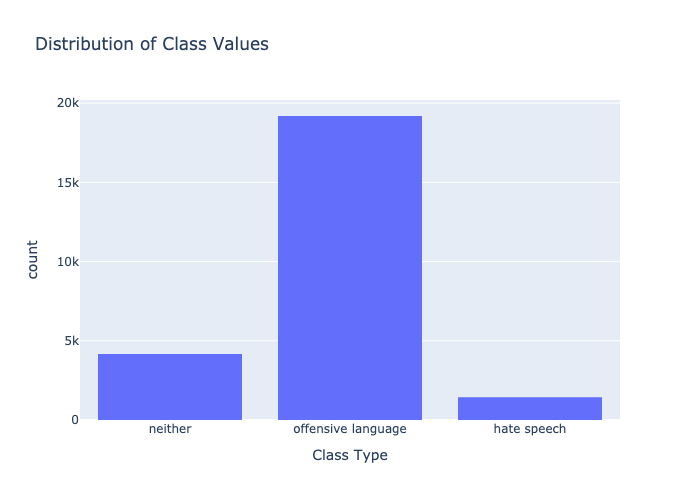

In [5]:
class_mapping = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}
df['class_label'] = df['class'].map(class_mapping)

fig = px.histogram(df, x='class_label', title='Distribution of Class Values', labels={'class_label': 'Class Type'})

# Show the plot
fig.show('png')




# preprocessing the tweet column

Using the same strategy the paper used to preprocess the tweet column in Davidson et al. 2017

In [6]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )



In [7]:
# remove the class offensive language

df = df[df['class'] != 1]

tweets = df.tweet
tfidf = vectorizer.fit_transform(tweets).toarray()

/Users/heksaani/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/heksaani/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.



In [8]:
tfidf.shape   

(5593, 2595)

In [9]:
df['class'].shape

(5593,)

In [23]:
X = tfidf
y = df['class']
#change 2 to 1
y = y.replace(2, 1)

In [24]:
y

0        1
40       1
63       1
66       1
67       1
        ..
24767    1
24776    0
24777    0
24779    1
24782    1
Name: class, Length: 5593, dtype: int64

## Train test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.8319928507596068


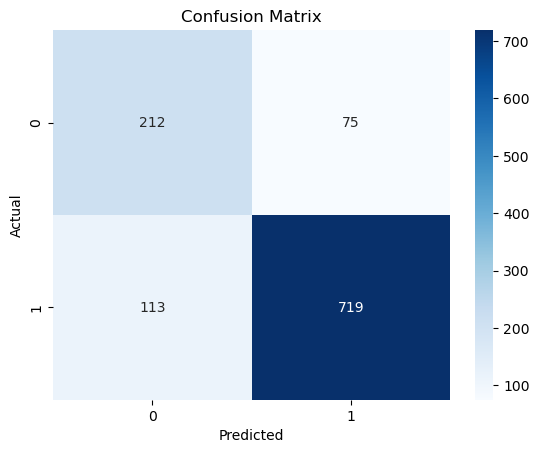

In [29]:
# use Naive Bayes

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)

print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# NOTES 
I've already previously used stemming and lemmatization in the preprocessing of the tweet column. Been a while since I've done this so here's some notes about the process.

Stemming: <br> is the process of reducing a word to its word stem, meaning the root form of the word. It is used in text processing to reduce words to their root form. For example, the words "running" and "runs" will be reduced to "run" after stemming ([DataCamp](https://www.datacamp.com/tutorial/stemming-lemmatization-python)).


TF-IDF matrix: <br>
Term Frequency — Inverse Document Frequency is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the collection of documents ([Medium](https://medium.com/@swamy.annamalai/tf-idf-in-depth-understanding-48fee2736419)).

